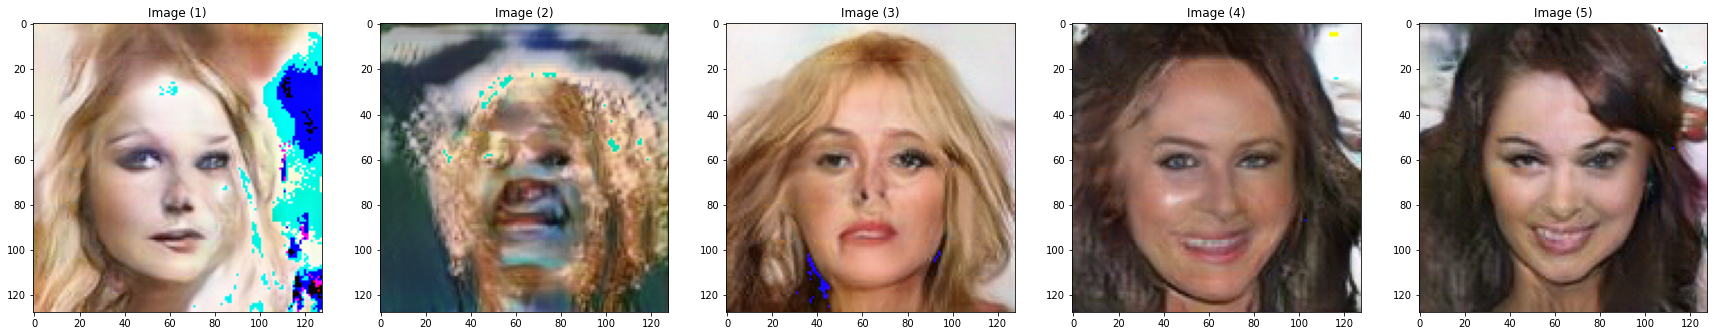

Iterations:  2000


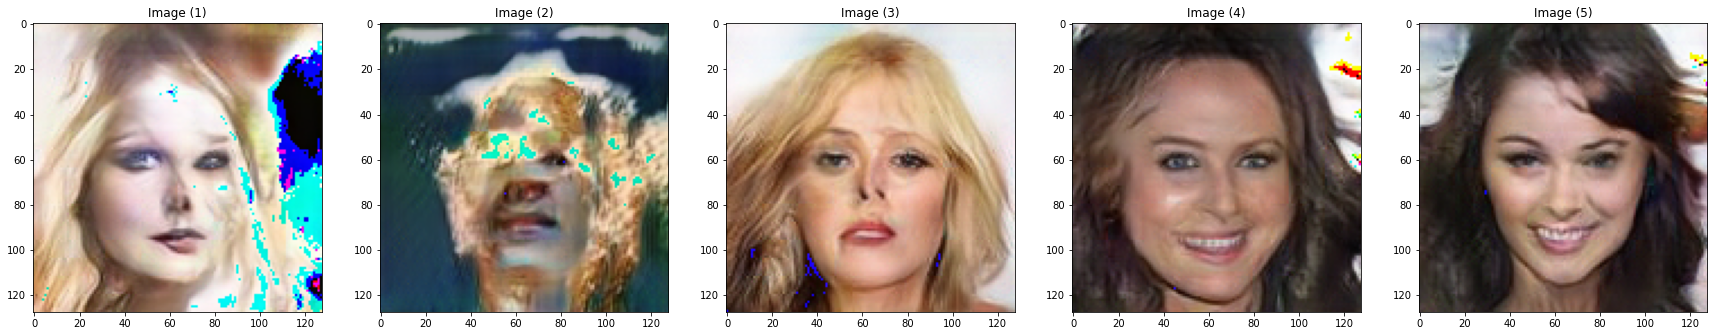

Iterations:  4000


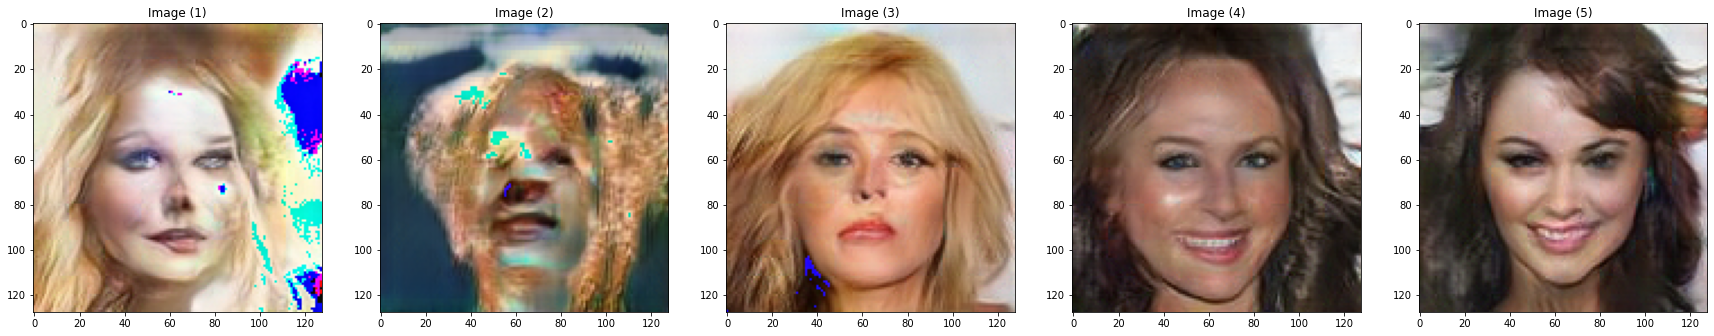

Iterations:  6000


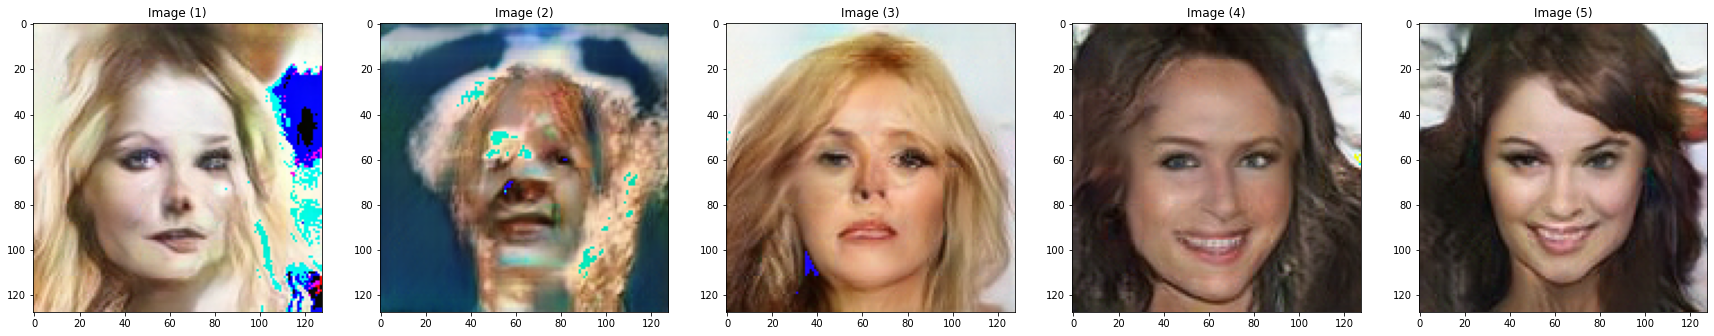

Iterations:  8000


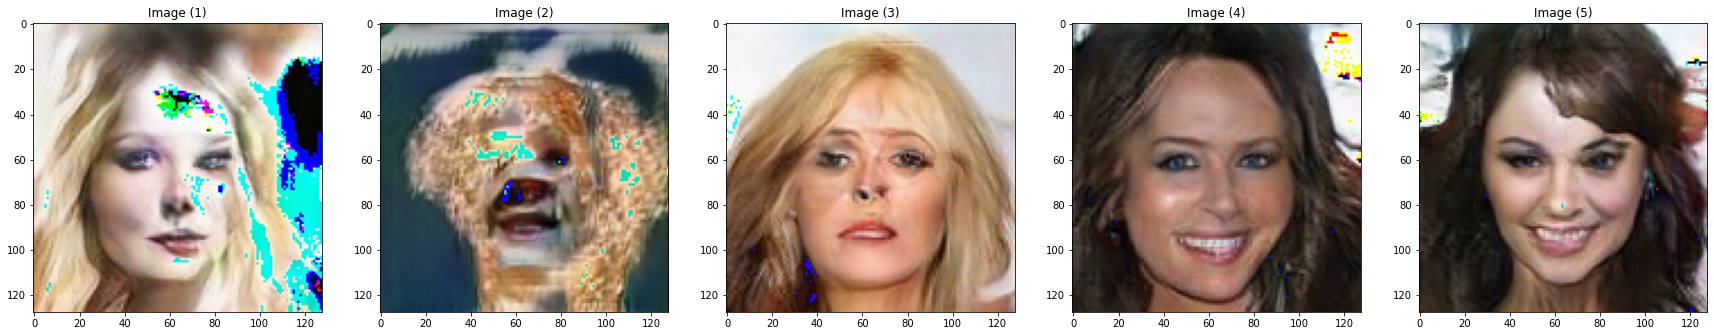

Iterations:  10000


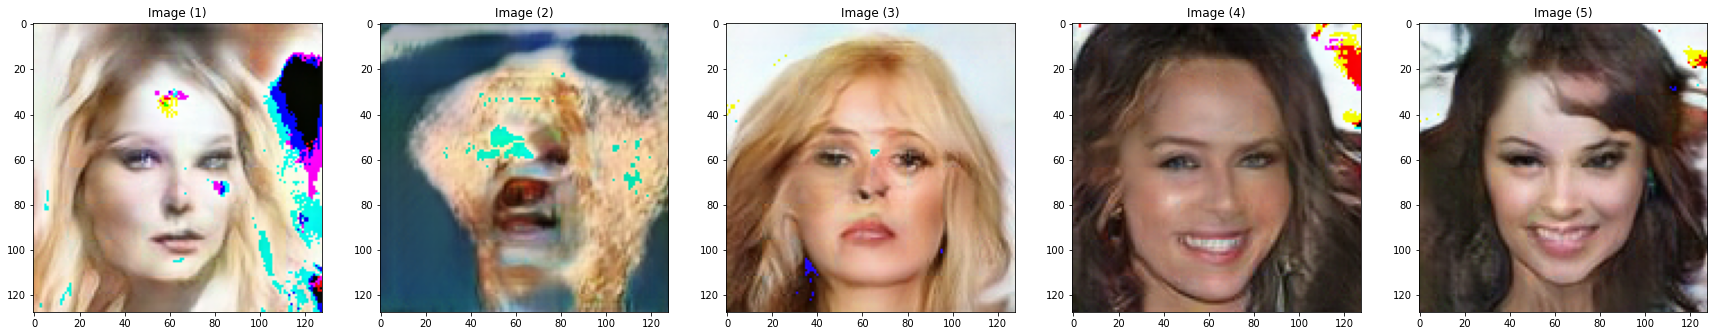

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: E:\Machine Learning & A.I\Saved Models\CelebA Generator 128\assets
INFO:tensorflow:Assets written to: E:\Machine Learning & A.I\Saved Models\CelebA Critic 128\assets


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers, backend
import numpy as np
import PIL
from PIL import Image
import time
import os
import random

gen_path = "E:\Machine Learning & A.I\Saved Models\CelebA Generator 128"
crit_path = "E:\Machine Learning & A.I\Saved Models\CelebA Critic 128"
path = r"E:\Machine Learning & A.I\Celeb A HQ Dataset\celeba_hq\train\Both 128"

BATCH_SIZE = 16
seed = tf.random.normal([BATCH_SIZE,100])

glim = 10
conv_lim = keras.constraints.min_max_norm(min_value=(-glim), max_value=glim, axis=[0,1,2])
dense_lim = keras.constraints.min_max_norm(min_value=(-glim), max_value=glim)
b_lim = keras.constraints.min_max_norm(min_value=(-glim), max_value=glim)

clim = 10 #critic weight/bias limit
cr_conv = conv_lim = keras.constraints.min_max_norm(min_value=(-clim), max_value=clim, axis=[0,1,2])
cr_dense = conv_lim = keras.constraints.min_max_norm(min_value=(-clim), max_value=clim)
cr_bias = conv_lim = keras.constraints.min_max_norm(min_value=(-clim), max_value=clim)



def image_generator(pictures): 
    for jpg in pictures:
        im = Image.open(path + "\\" + jpg) #Opens the image
        im_arr = np.asarray(im, dtype='float32')
        im_arr = (im_arr-127.5)/127.5
        yield im_arr
        
def generate_images(model):
    generated_images = []
    #sd = tf.random.normal([BATCH_SIZE,100])
    new_img = model(seed, training=False)
    for i in range(5):
        x = new_img[i].numpy()
        x = (x*127.5)+127.5
        final = x.astype('uint8')
        generated_images.append(final)
    return generated_images

class PrevAlphaMod(layers.Layer):
    def __init__(self):
        super (PrevAlphaMod, self).__init__()
        self.alpha = backend.variable(0, dtype='float32')
    def call(self, tensor):
        return (1.0 - self.alpha) * tensor
        
class CurrentAlphaMod(layers.Layer):
    def __init__(self):
        super (CurrentAlphaMod, self).__init__()
        self.alpha = backend.variable(0, dtype='float32')
    def call(self, tensor):
        return self.alpha * tensor

#Applies the per-pixel normalization specified by the paper
class PixelNorm(layers.Layer):
    #custom layers don't need a constructor
    def call(self, tensor):
        return tensor/ tf.sqrt(tf.reduce_mean(tf.square(tensor),axis=1,keepdims=True)+10**(-8))
    
def add_gen_block(gen, step, connect=(-6)):
    #replaces the final layer with a new upsampling layer
    start = gen.layers[connect].output
    x = layers.UpSampling2D(size=(2,2), name='upsamp1_'+str(step))(start)
    
    #the standard convolutional-step layers
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',kernel_constraint=conv_lim,
                     bias_constraint=b_lim,name='conv2d1_'+str(step))(x)
    x = PixelNorm(name='pixel_norm1_'+str(step))(x)
    x = layers.LeakyReLU(name='leaky_relu_1'+str(step))(x)
    
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',kernel_constraint=conv_lim,
                     bias_constraint=b_lim,name='conv2d2_'+str(step))(x)
    x = PixelNorm(name='pixel_norm2_'+str(step))(x)
    raw = layers.LeakyReLU(name='leaky_relu_2'+str(step))(x)
    rgb = layers.Conv2D(3, (1,1), padding='same',activation='tanh',kernel_initializer='he_normal',
                kernel_constraint=conv_lim, bias_constraint=b_lim,name='to_rgb_this_'+str(step))(raw)
    
    prev_rgb = layers.Conv2D(3, (1,1), padding='same',activation='tanh',kernel_initializer='he_normal',
                kernel_constraint=conv_lim, bias_constraint=b_lim,name='to_rgb_prev_'+str(step))(start)
    prev_up = layers.UpSampling2D(size=(2,2),name='upsamp2_'+str(step))(prev_rgb)
    
    prev_a = PrevAlphaMod()(prev_up)
    this_a = CurrentAlphaMod()(rgb)
    ws = layers.Add()([prev_a, this_a])
    
    model = keras.Model(inputs=gen.input, outputs=ws)
    return model

def add_critic_block(disc, step):
    skip=[2,4,6,8,9,10] #removes the alpha weighting layers
    dim = step + 2
    new_disc = keras.Input(shape=(2**dim, 2**dim, 3))
    
    #PREVIOUS THROUGH PATH
    prev_down = layers.AveragePooling2D(pool_size=(2,2),name='avg_pool2d_1'+str(step))(new_disc)
    prev_rgb = layers.Conv2D(64, (1,1),padding='same',kernel_initializer='he_normal',
        kernel_constraint=cr_conv, bias_constraint=cr_bias, name='conv2d1_'+str(step))(prev_down)
    prev_out = layers.LeakyReLU(name='leaky_relu_1'+str(step))(prev_rgb)
    prev_alpha = PrevAlphaMod()(prev_out)
    
    #SELF THROUGH PATH
    #from rgb layer
    from_rgb = layers.Conv2D(64, (1,1),padding='same',kernel_initializer='he_normal',
            kernel_constraint=cr_conv, bias_constraint=cr_bias, name='conv2d2_'+str(step))(new_disc) 
    
    #the standard convolutional-step layers
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',
        kernel_constraint=cr_conv, bias_constraint=cr_bias, name='conv2d3_'+str(step))(from_rgb)
    x = layers.LeakyReLU(name='leaky_relu_2'+str(step))(x)
    
    x = layers.Conv2D(64, (3,3), padding='same',kernel_initializer='he_normal',
        kernel_constraint=cr_conv, bias_constraint=cr_bias, name='conv2d4_'+str(step))(x)
    x = layers.LeakyReLU(name='leaky_relu_3'+str(step))(x)
    
    this_down = layers.AveragePooling2D(pool_size=(2,2), name='avg_pool2d_2'+str(step))(x)
    this_alpha = CurrentAlphaMod()(this_down)
    
    out = layers.Add()([prev_alpha, this_alpha])
    
    if step == 1:
        for layer in disc.layers[2:]:
                out = layer(out)
    else:
        for index, layer in enumerate(disc.layers[2:]):
            if index not in skip:
                out = layer(out)
            
    model = keras.Model(inputs=new_disc, outputs=out)
    return model

@tf.function
def train_critic(images):
    noise = tf.random.normal([BATCH_SIZE,100])
    #adds random noise to the input images 
    images += 0.05 * tf.random.uniform(images.shape)

    with tf.GradientTape() as crit_tape:
        fake_images = generator(noise, training=False)
        fake_out = tf.reduce_mean(critic(fake_images))
        real_out = tf.reduce_mean(critic(images))
        grad_pen = gradient_penalty(images, fake_images)**2
        crit_loss = fake_out - real_out + (10*grad_pen)
        
    crit_grads = crit_tape.gradient(crit_loss, critic.trainable_variables)    
    critic_optimizer.apply_gradients(zip(crit_grads, critic.trainable_variables))
    return crit_loss

@tf.function
def train_generator():
    noise = tf.random.normal([(BATCH_SIZE*2), 100])
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise)
        fake_out = critic(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_out)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    return gen_loss

@tf.function
def gradient_penalty(images, fake_img):
    epsi = tf.random.uniform(shape=[BATCH_SIZE,1,1,1], maxval=1)
    
    diff = fake_img - images
    interpolated = images + epsi * diff
    
    with tf.GradientTape() as x_hat_tape:
        x_hat_tape.watch(interpolated)
        x_hat_out = critic(interpolated)
    x_hat_grads = x_hat_tape.gradient(x_hat_out, [interpolated])[0]
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(x_hat_grads), axis=[1,2,3]))
    return tf.reduce_mean((norm-1)**2)

def train():
    epochs = 10000
    n_critic= 5
    pictures = os.listdir(path)
    loops = int(17943/BATCH_SIZE)
    imgs = generate_images(generator)
    show_images(imgs)
    step = 1/(epochs*0.9)
    ws_alpha = 0
    
    for i in range(epochs):
        for _ in range(n_critic):
            images = []
            for _ in range(BATCH_SIZE):
                jpg = random.choice(pictures)
                im = Image.open(path + "\\" + jpg) #Opens the image
                im_arr = np.asarray(im, dtype='float32')
                im_arr = (im_arr-127.5)/127.5
                images.append(im_arr)
            img_tensor = tf.convert_to_tensor(np.asarray(images))
            _ = train_critic(img_tensor)
            #_ = gradient_penalty(img_tensor, generator(tf.random.normal([BATCH_SIZE,100])))
            
        _ = train_generator()
        
        if False: #i < (epochs*0.5)
            ws_alpha += step 
            for layer in generator.layers:
                if isinstance(layer, (PrevAlphaMod, CurrentAlphaMod)):
                    if layer.alpha < 1:
                        backend.set_value(layer.alpha, ws_alpha)
                    elif layer.alpha > 1:
                        backend.set_value(layer.alpha, 1)
            for layer in critic.layers:
                if isinstance(layer, (PrevAlphaMod, CurrentAlphaMod)):
                    if layer.alpha < 1:
                        backend.set_value(layer.alpha, ws_alpha)
                    elif layer.alpha > 1:
                        backend.set_value(layer.alpha, 1)
        if (i+1)%2000 == 0 or (1+i) == epochs:
            print("Iterations: ", i+1)
            imgs = generate_images(generator)
            show_images(imgs)

    generator.save("E:\Machine Learning & A.I\Saved Models\CelebA Generator 128")
    critic.save("E:\Machine Learning & A.I\Saved Models\CelebA Critic 128")
            
generator = models.load_model(gen_path)
critic = models.load_model(crit_path)

#critic = add_critic_block(critic, 5)
#generator = add_gen_block(generator, 5)#, connect=(-2))

generator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)
critic_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)

train()